In [6]:
# Hotel Booking Preprocessing Pipeline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
from sklearn.model_selection import train_test_split

In [7]:
# Load data
file_path = "/kaggle/input/hotel-bookings-dataset/hotel_bookings.csv"
df = pd.read_csv(file_path)

=== DataFrame .info() ===
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 119390 entries, 0 to 119389
Data columns (total 32 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   hotel                           119390 non-null  object 
 1   is_canceled                     119390 non-null  int64  
 2   lead_time                       119390 non-null  int64  
 3   arrival_date_year               119390 non-null  int64  
 4   arrival_date_month              119390 non-null  object 
 5   arrival_date_week_number        119390 non-null  int64  
 6   arrival_date_day_of_month       119390 non-null  int64  
 7   stays_in_weekend_nights         119390 non-null  int64  
 8   stays_in_week_nights            119390 non-null  int64  
 9   adults                          119390 non-null  int64  
 10  children                        119386 non-null  float64
 11  babies                          119390 non-null  int

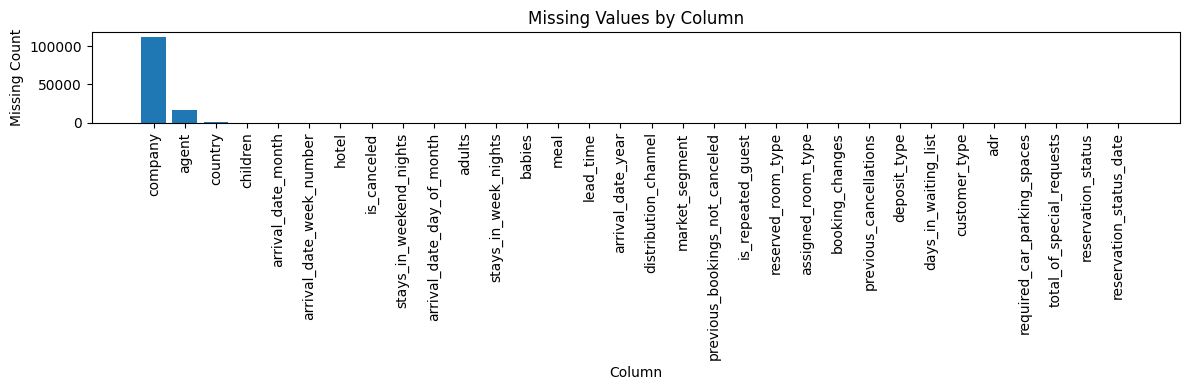

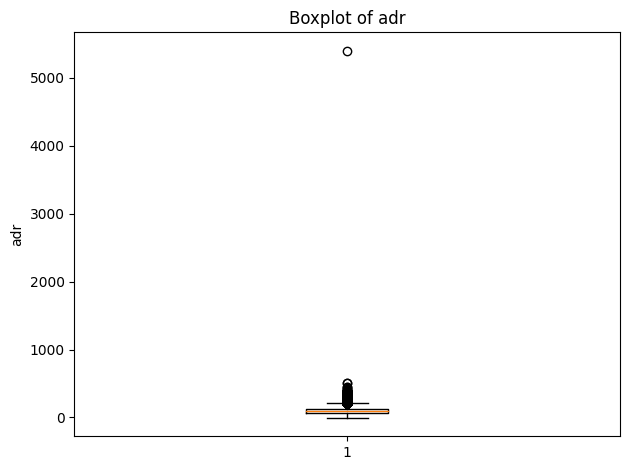

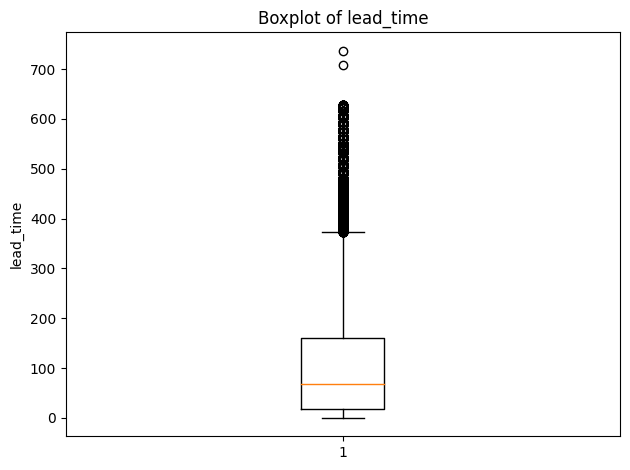

IQR bounds for adr: lower=-15.77, upper=211.06
IQR bounds for lead_time: lower=-195.00, upper=373.00


In [8]:
# -----------------------------
# Phase 1: EDA & Data Quality
# -----------------------------
print("=== DataFrame .info() ===")
df.info()
print("\n=== DataFrame .describe(include='all') ===")
print(df.describe(include="all").T)

# Missing values
missing_counts = df.isnull().sum().sort_values(ascending=False)
missing_df = pd.DataFrame({
    "column": missing_counts.index,
    "missing_count": missing_counts.values,
    "missing_pct": (missing_counts.values / len(df)).round(4)
})
print("\n=== Missing Values Report ===")
print(missing_df)

# Plot missing values bar chart
plt.figure(figsize=(12,4))
plt.bar(missing_df["column"], missing_df["missing_count"])
plt.title("Missing Values by Column")
plt.xlabel("Column")
plt.ylabel("Missing Count")
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

# Detect outliers: Boxplots for 'adr' and 'lead_time'
for col in ["adr", "lead_time"]:
    if col in df.columns:
        plt.figure()
        plt.boxplot(df[col].dropna(), vert=True)
        plt.title(f"Boxplot of {col}")
        plt.ylabel(col)
        plt.tight_layout()
        plt.show()

# IQR helper
def iqr_bounds(series):
    q1 = series.quantile(0.25)
    q3 = series.quantile(0.75)
    iqr = q3 - q1
    return q1 - 1.5 * iqr, q3 + 1.5 * iqr

if "adr" in df.columns:
    adr_lower, adr_upper = iqr_bounds(df["adr"].dropna())
    print(f"IQR bounds for adr: lower={adr_lower:.2f}, upper={adr_upper:.2f}")
if "lead_time" in df.columns:
    lt_lower, lt_upper = iqr_bounds(df["lead_time"].dropna())
    print(f"IQR bounds for lead_time: lower={lt_lower:.2f}, upper={lt_upper:.2f}")


In [10]:
# -----------------------------
# Phase 2: Data Cleaning
# -----------------------------
clean = df.copy()

# Handle Missing Values
for col in ["company", "agent"]:
    if col in clean.columns:
        clean[col] = clean[col].fillna(0).astype(int)

if "country" in clean.columns:
    mode_country = clean["country"].mode(dropna=True)[0]
    clean["country"] = clean["country"].fillna(mode_country)

if "children" in clean.columns:
    median_children = clean["children"].median()
    clean["children"] = clean["children"].fillna(median_children)

# Remove Duplicates
clean = clean.drop_duplicates()

# Handle Outliers in adr
if "adr" in clean.columns:
    clean.loc[clean["adr"] < 0, "adr"] = 0
    clean.loc[clean["adr"] > 1000, "adr"] = 1000

# Drop rows with zero guests
if set(["adults", "children", "babies"]).issubset(clean.columns):
    clean = clean[(clean["adults"] + clean["children"] + clean["babies"]) > 0]

# Fix Data Types
if "reservation_status_date" in clean.columns:
    clean["reservation_status_date"] = pd.to_datetime(clean["reservation_status_date"], errors="coerce")

if set(["arrival_date_year", "arrival_date_month", "arrival_date_day_of_month"]).issubset(clean.columns):
    def parse_arrival(row):
        try:
            month_num = datetime.strptime(str(row["arrival_date_month"]), "%B").month
            return datetime(int(row["arrival_date_year"]), month_num, int(row["arrival_date_day_of_month"]))
        except Exception:
            return pd.NaT
    clean["arrival_date"] = clean.apply(parse_arrival, axis=1)


In [11]:
# -----------------------------
# Phase 3: Feature Engineering
# -----------------------------
clean["total_guests"] = clean["adults"] + clean["children"] + clean["babies"]
clean["total_nights"] = clean["stays_in_weekend_nights"] + clean["stays_in_week_nights"]
clean["is_family"] = ((clean["children"] + clean["babies"]) > 0).astype(int)

# Drop leakage
clean = clean.drop(columns=["reservation_status", "reservation_status_date"], errors="ignore")

# Encoding
cat_cols = clean.select_dtypes(include=["object"]).columns.tolist()
freq_encoded = pd.DataFrame(index=clean.index)

if "country" in cat_cols:
    country_freq = clean["country"].value_counts(normalize=True)
    freq_encoded["country_freq"] = clean["country"].map(country_freq)
    cat_cols.remove("country")

low_card_cols = [c for c in cat_cols if clean[c].nunique() <= 20]
high_card_cols = [c for c in cat_cols if c not in low_card_cols]

for c in high_card_cols:
    top_cats = set(clean[c].value_counts().head(10).index)
    clean[c] = clean[c].where(clean[c].isin(top_cats), other="Other")

ohe_cols = low_card_cols + high_card_cols
clean_ohe = pd.get_dummies(clean, columns=ohe_cols, drop_first=False)

if not freq_encoded.empty:
    clean_ohe = pd.concat([clean_ohe, freq_encoded], axis=1)


In [12]:
# -----------------------------
# Phase 4: Final Preparation
# -----------------------------
y = clean_ohe["is_canceled"].astype(int)
X = clean_ohe.drop(columns=["is_canceled"])

X = X.fillna(0)  # final safety net

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print("Final shapes:")
print("X_train:", X_train.shape, "X_test:", X_test.shape)
print("y_train:", y_train.shape, "y_test:", y_test.shape)

Final shapes:
X_train: (69768, 84) X_test: (17443, 84)
y_train: (69768,) y_test: (17443,)
